In [290]:
import numpy as np
import pandas as pd
# import data_collection as dc

import psycopg2
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import linear_rainbow, het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import LabelEncoder

import assumption_check as ac 

In [291]:
## code to open sql files. Dont need it now

# file_obj = open('../src/sql/05_pull_extr_rpsale_2019.sql')

# file_contents = file_obj.read()
# file_obj.close()

# file_contents
# df_test = pd.read_sql(file_contents, conn)

#### Import data

In [292]:

dbname = "king_house"

conn = psycopg2.connect(dbname = dbname)

df_sale = pd.read_sql("""
SELECT *

FROM extr_rpsale
""", conn)

df_rdb = pd.read_sql("""
SELECT *

FROM extr_resbldg
""", conn)

df_parcel = pd.read_sql("""
SELECT *

FROM extr_parcel

""", conn)

df_lookup = pd.read_sql("""
SELECT *

FROM look_up

""", conn)


### Create tables

In [293]:
df_lookup = df_lookup[df_lookup['LUType'] != 'LUType']
df_lookup.head()

,LUType,LUItem,LUDescription
1,1,1,LAND ONLY ...
2,1,10,Land with new building ...
3,1,11,"Household, single family units ..."
4,1,12,"Multiple family residence (Residential, 2-4 un..."
5,1,13,"Multiple family residence (Residential, 5+ uni..."


In [294]:
# Selcted variables from the residenstial building dataset:

df_rdb = df_rdb[df_rdb['Major'] != 'Major']
df_rdb['HID'] = df_rdb['Major'].str.zfill(6) + '-'+ df_rdb['Minor'].str.zfill(4)

# columns = ['Major', 'Minor', 'SqFt1stFloor', 'SqFtHalfFloor', 'SqFt2ndFloor',
#             'SqFtUpperFloor', 'SqFtUnfinFull', 'SqFtUnfinHalf', 'SqFtTotLiving',
#             'SqFtTotBasement', 'SqFtFinBasement', 'FinBasementGrade','SqFtGarageBasement', 
#             'SqFtGarageAttached', 'DaylightBasement','SqFtOpenPorch', 'SqFtEnclosedPorch', 'SqFtDeck',
#             'Bedrooms','BathHalfCount', 'Bath3qtrCount', 'BathFullCount', 'HID']
# df_rdb_set = df_rdb.loc[:, columns]
# df_rdb_set.head()

In [295]:
df_rdb.columns

Index(['Major', 'Minor', 'BldgNbr', 'NbrLivingUnits', 'Address',
       'BuildingNumber', 'Fraction', 'DirectionPrefix', 'StreetName',
       'StreetType', 'DirectionSuffix', 'ZipCode', 'Stories', 'BldgGrade',
       'BldgGradeVar', 'SqFt1stFloor', 'SqFtHalfFloor', 'SqFt2ndFloor',
       'SqFtUpperFloor', 'SqFtUnfinFull', 'SqFtUnfinHalf', 'SqFtTotLiving',
       'SqFtTotBasement', 'SqFtFinBasement', 'FinBasementGrade',
       'SqFtGarageBasement', 'SqFtGarageAttached', 'DaylightBasement',
       'SqFtOpenPorch', 'SqFtEnclosedPorch', 'SqFtDeck', 'HeatSystem',
       'HeatSource', 'BrickStone', 'ViewUtilization', 'Bedrooms',
       'BathHalfCount', 'Bath3qtrCount', 'BathFullCount', 'FpSingleStory',
       'FpMultiStory', 'FpFreestanding', 'FpAdditional', 'YrBuilt',
       'YrRenovated', 'PcntComplete', 'Obsolescence', 'PcntNetCondition',
       'Condition', 'AddnlCost', 'HID'],
      dtype='object')

In [296]:
# Selected variables from the parcel dataset:
df_parcel = df_parcel[df_parcel['Major'] != 'Major']
df_parcel['HID'] = df_parcel['Major'].str.zfill(6) + '-' + df_parcel['Minor'].str.zfill(4)

# columns = ['Major', 'Minor', 'SqFtLot','WfntLocation', 
#            'TrafficNoise', 'AirportNoise', 'PowerLines', 'OtherNuisances', 'HID'] 
# df_parcel_set = df_parcel.loc[:, columns]
df_parcel.shape

#'PugetSound', 'LakeWashington','LakeSammamish', 'SmallLakeRiverCreek',

(614337, 83)

In [297]:
# Selseted variables from the property sale dataset: 

df_sale = df_sale[df_sale['Major'] != 'Major']

df_sale['HID'] = df_sale['Major'].str.zfill(6) + '-' + df_sale['Minor'].str.zfill(4)
df_sale_2019_set = df_sale[df_sale['DocumentDate'].str.contains('2019')]

# columns = ['Major', 'Minor', 'DocumentDate', 'SalePrice', 'PropertyType', 'HID']
# df_sale_2019_set = df_sale_2019.loc[:, columns]
# df_sale_2019_.head()
df_sale_2019_set.shape

(60933, 25)

In [298]:
# Join 3 datasets together

df_combine = df_sale_2019_set.merge(df_parcel, how='inner', on='HID')
df_combine = df_combine.merge(df_rdb, how='inner', on='HID')

In [299]:
df_combine.columns
df_combine.shape

(43545, 157)

In [310]:
king_house_2019 = df_combine

In [311]:
king_house_2019 = king_house_2019.astype(
                     {'SalePrice':'float',
                      'SqFtLot':'float',  
                      'SqFt1stFloor':'float', 
                       'SqFtHalfFloor':'float',
                       'SqFt2ndFloor':'float', 
                       'SqFtUpperFloor':'float', 
                       'SqFtUnfinFull':'float', 
                       'SqFtUnfinHalf':'float',
                       'SqFtTotLiving':'float', 
                       'SqFtTotBasement':'float', 
                       'SqFtFinBasement':'float',
                       'FinBasementGrade':'float', 
                       'SqFtGarageBasement':'float', 
                       'SqFtGarageAttached':'float',
                       'SqFtOpenPorch':'float', 
                       'SqFtEnclosedPorch':'float', 
                       'SqFtDeck':'float',
                       'Bedrooms':'float', 
                       'BathHalfCount':'float', 
                       'Bath3qtrCount':'float', 
                       'BathFullCount':'float',
                       'TrafficNoise': 'int', 
                       'AirportNoise':'float',
                       }
                      )

In [312]:
# king_house_2019.head()

In [319]:
cols = list(king_house_2019.columns)
cols = [cols[2]] + cols[:2] + cols[3:]
king_house_2019 = king_house_2019[cols]
king_house_2019 = king_house_2019[(
                                   (king_house_2019['PropertyType'] == '11') 
                                  |(king_house_2019['PropertyType'] == '12') 
                                  |(king_house_2019['PropertyType'] == '13') 
                                  |(king_house_2019['PropertyType'] == '14') 
                                )
                                  & (king_house_2019.SalePrice >= 50000)]

In [320]:
# king_house_2019 = king_house_2019.drop(columns = ['Major_x', 'Major_y', 'Minor_x', 'Minor_y', 'DocumentDate', 'Major', 'Minor'])
# king_house_2019 = king_house_2019.drop(columns = 'DocumentData')

In [321]:
king_house_2019.iloc[:, 13:30].head(20)

king_house_2019['SqlTotal'] = king_house_2019['SqFt1stFloor'] + king_house_2019['SqFtHalfFloor'] + king_house_2019['SqFt2ndFloor']\
                         + king_house_2019['SqFtUpperFloor'] + king_house_2019['SqFtUnfinFull'] + king_house_2019['SqFtUnfinHalf']\
                         + king_house_2019['SqFtTotBasement'] + king_house_2019['SqFtFinBasement'] + king_house_2019['FinBasementGrade']\
                         + king_house_2019['SqFtGarageBasement'] + king_house_2019['SqFtGarageAttached'] \
                         + king_house_2019['SqFtOpenPorch'] + king_house_2019['SqFtEnclosedPorch'] + king_house_2019['SqFtDeck']

king_house_2019['pwrlines'] = king_house_2019['PowerLines'] == 'Y'
king_house_2019['othernuisance'] = king_house_2019['OtherNuisances']=='Y'

In [327]:
king_house_2019['nuisance_total'] = (
    king_house_2019['AirportNoise'] +
    king_house_2019['TrafficNoise'] +
    king_house_2019['pwrlines'] +
    king_house_2019['othernuisance']
)

In [324]:
king_house_2019['PorchTotal']=king_house_2019.SqFtOpenPorch + king_house_2019.SqFtEnclosedPorch

In [325]:
king_house_2019['is_waterfront'] = (king_house_2019['WfntLocation'] != '0').astype(int)

In [326]:
king_house_2019['BathTotal'] = king_house_2019['BathHalfCount']*0.5 + king_house_2019['Bath3qtrCount'] * 0.75 + king_house_2019['BathFullCount']

In [329]:
# df_lookup_w = df_lookup[df_lookup['LUType']=='1  ']

# df_lookup_w.head(10)

In [330]:
king_house_2019['PorchTotal'] = king_house_2019['SqFtOpenPorch'] + king_house_2019['SqFtEnclosedPorch']
king_house_2019['is_porch'] = (king_house_2019['PorchTotal']==0).astype('int')

In [333]:
king_house_2019.columns

Index(['Major_x', 'Minor_x', 'ExciseTaxNbr', 'DocumentDate', 'SalePrice',
       'RecordingNbr', 'Volume', 'Page', 'PlatNbr', 'PlatType',
       ...
       'Condition', 'AddnlCost', 'SqlTotal', 'pwrlines', 'othernuisance',
       'nuisance_total', 'PorchTotal', 'is_waterfront', 'BathTotal',
       'is_porch'],
      dtype='object', length=165)

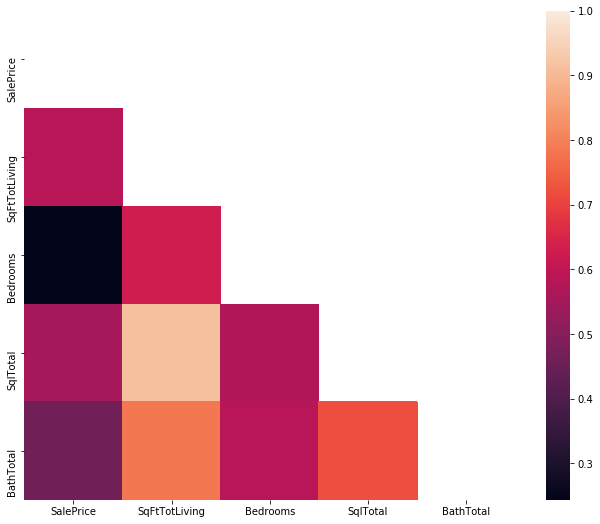

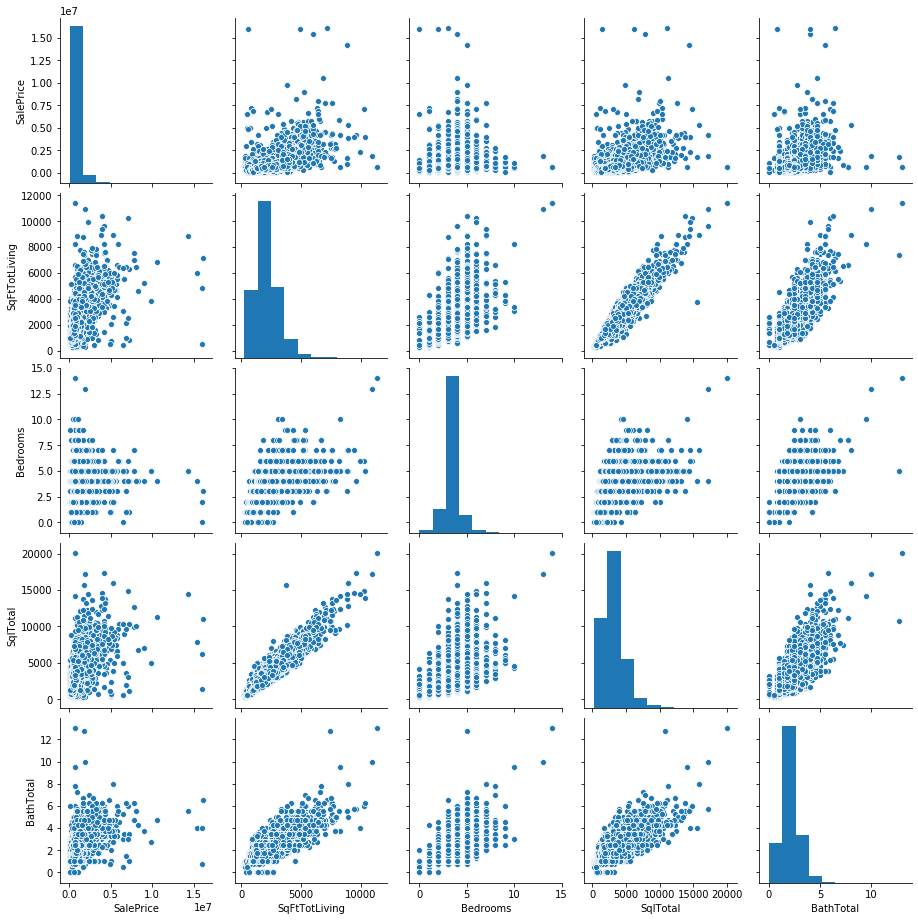

In [341]:
columns = ['SalePrice','SqFtTotLiving', 'Bedrooms', 'SqlTotal', 'BathTotal']
df = king_house_2019[columns]
colrelation = ac.correlation_fig(df)

In [350]:
columns = ['SalePrice', 'SqlTotal']
df = king_house_2019

In [351]:
kh_base = ac.create_df(df, columns)

kh_base_model = ac.create_model(kh_base)

model_summary = ac.model_summary(kh_base_model)
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          df.iloc[:, 0]   R-squared:                       0.307
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     8815.
Date:                Wed, 04 Mar 2020   Prob (F-statistic):               0.00
Time:                        16:04:15   Log-Likelihood:            -2.8942e+05
No. Observations:               19877   AIC:                         5.789e+05
Df Residuals:                   19875   BIC:                         5.789e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1.028e+05   8270.669     12.430      0.000    8.66e+04    1.19e+05
df.iloc[:, 1:]   218.6473      2.329     93.888      0.000     214.083     223.212
==============================================================================
Omnibus:                    28274.454   Durbin-Watson:                   1.774
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         23395327.835
Skew:                           8.079   Prob(JB):                         0.00
Kurtosis:                     170.293   Cond. No.                     8.12e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.12e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Check liniear regression assumtions linearity:

In [352]:
check = ac.linearity_check(kh_base_model)

Rainbow statistic: 0.9172737175345063
Rainbow p-value: 0.9999915821247763


The null hypothesis is that the model is linearly predicted by the features,alternative hypothesis is that it is not. Thus returning a low p-value means that the current model violates the linearity assumption.


### Check Normality

The Jarque-Bera test is performed automatically as part of the model summary output, labeled Jarque-Bera (JB) and Prob(JB).

The null hypothesis is that the residuals are normally distributed, alternative hypothesis is that they are not. Thus returning a low p-value means that the current model violates the normality assumption.

In [353]:
ac.normality_check()

The Jarque-Bera test is performed automatically as part of the model summary output, labeled Jarque-Bera (JB) and Prob(JB).    

The null hypothesis is that the residuals are normally distributed, alternative hypothesis is that they are not. Thus returning a low p-value means that the current model violates the normality assumption.


### Check Homoscadasticity:
Linear regression assumes that the variance of the dependent variable is homogeneous across different value of the independent variable(s). We can visualize this by looking at the predicted dependent variable values vs. the residuals.

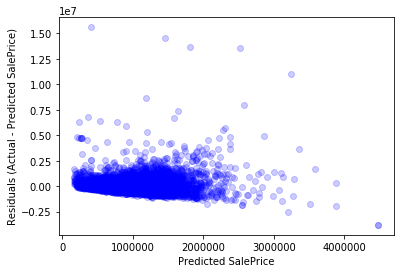

In [354]:
ac.homosdt_check_fig(kh_base, kh_base_model)

In [355]:
ac.homosdt_check_test(kh_base, kh_base_model)

Lagrange Multiplier p-value: nan
F-statistic p-value: 1.4707907908295052e-64


The null hypothesis is homoscedasticity, alternative hypothesis is heteroscedasticity.Thus returning a low p-value means that the current model violates the homoscedasticity assumption


### Check Independence:
The independence assumption means that the independent variables must not be too collinear. If we have only one independent variable, so we don't need to check this.

In [361]:
# model 2: add new second variable is_water:
columns = ['SalePrice', 'SqlTotal', 'is_waterfront']
df = king_house_2019

kh_model2 = ac.create_df(df, columns)